In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy


from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.linearWaveModels import linear_w_1layer,w_to_Tprime,linear_w_generalized
from tools.generalTools import compute_N
from tools.wrfHrTools import *

SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

In [3]:
m06 = Simulation('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.500m.6mps.10km/',487,10)
m08 = Simulation('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.500m.8mps.10km/',487,10)
m10 = Simulation('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.500m.10mps.10km/',487,10)
m12 = Simulation('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.500m.12mps.10km/',487,10)
m14 = Simulation('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.500m.14mps.10km/',487,10)
sims = (m06,m08,m10,m12,m14)

In [4]:
def hatprime(var,idx1,idx2):
    """Vertically average variable between two pressure levels indicated by their indices (idx1 and idx2), and take deviation from upstream value"""
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat.sel(distance_from_mtn=slice(-3000,-4500)).mean('distance_from_mtn')

In [5]:
hgt=change_coords_sfc(m10.data.HGT[0,0],center=m10.center,dx=m10.dx)

# Temperature vs time

In [34]:
def subtract_init(var):
    return var - var.isel(Time=0)
def temp_subset(sim):
    return subtract_init(sim.data.T[:,9,:,492].mean('south_north')-sim.data.T[:,9,:,800:900].mean(['south_north','west_east']))



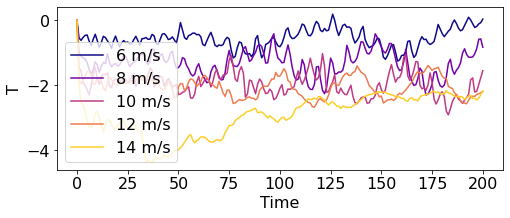

In [49]:
plt.figure(figsize=(8,3))
winds=[6,8,10,12,14]
colors=plt.cm.plasma(np.linspace(0,0.9,len(winds)))
for u,sim,c in zip(winds,sims,colors):
    temp_subset(sim).plot(label="%i m/s"%u,color=c)
plt.legend()

# T,q anomalies

In [16]:
["/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.dry.500m.{}mps.10km/wrfout_d01_days100-200_avg.nc".format(u) for u in range(6,15,2)]


['/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.dry.500m.6mps.10km/wrfout_d01_days100-200_avg.nc',
 '/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.dry.500m.8mps.10km/wrfout_d01_days100-200_avg.nc',
 '/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.dry.500m.10mps.10km/wrfout_d01_days100-200_avg.nc',
 '/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.dry.500m.12mps.10km/wrfout_d01_days100-200_avg.nc',
 '/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.dry.500m.14mps.10km/wrfout_d01_days100-200_avg.nc']

In [18]:
def create_xr_mean(sim,path):
    variables = ['U','V','W','PH','T','P','RHO','Q2','T2','PSFC','U10','V10','QVAPOR']
    dars=[]
    for var in variables:
        try:
            mean = sim.data[var][100:200].mean(['Time','south_north']).load().rename(var)
        except ValueError:
            mean = sim.data[var][100:200].mean(['Time','south_north_stag']).load().rename(var)
        dars.append(mean)
    xr.merge(dars).to_netcdf(path)

paths = ["/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.dry.500m.{}mps.10km/wrfout_d01_days100-200_avg.nc".format(u) for u in range(6,15,2)]
for sim,path in zip(sims,paths):
    %time create_xr_mean(sim,path)

CPU times: user 5.61 s, sys: 14.5 s, total: 20.1 s
Wall time: 17.1 s
CPU times: user 5.49 s, sys: 18.2 s, total: 23.7 s
Wall time: 21.3 s
CPU times: user 5.56 s, sys: 18.8 s, total: 24.4 s
Wall time: 22.1 s
CPU times: user 6.01 s, sys: 20.1 s, total: 26.1 s
Wall time: 23 s
CPU times: user 6.16 s, sys: 21.3 s, total: 27.4 s
Wall time: 23.7 s


In [6]:
%%time
for sim in sims:
    theta_temp = (300+sim.data.T[100:200]).mean(['Time','south_north']).load()
    thetamean = interp_eta_to_pressure(sim.data,change_coords_eta(sim.data,theta_temp,center=sim.center,dx=sim.dx),0,dsinput=sim.input)
    sim.tmeanbeg = thetamean*(thetamean.pressure/1e3)**0.286
    p1=5;p2=16
    sim.tmeanbeg_hat_prime = hatprime(sim.tmeanbeg,p1,p2)

    qv_temp = sim.data.QVAPOR[100:200].mean(['Time','south_north']).load()
    sim.qvmeanbeg = interp_eta_to_pressure(sim.data,change_coords_eta(sim.data,qv_temp,center=sim.center,dx=sim.dx),0,dsinput=sim.input)
    sim.qvmeanbeg_hat_prime = Lc/cp*hatprime(sim.qvmeanbeg,p1,p2) # convert to K
    

CPU times: user 8.87 s, sys: 41.3 s, total: 50.2 s
Wall time: 59.8 s


In [37]:
def linear_TdL(U,N=0.012):
    xx,hx = topographic_profile('cos',a=100e3,A=1000)
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    zbot=1000
    ztop=3000
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    etahat = np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)
    return xx/1000, -4e-3*np.real(np.fft.ifft(etahat))

Text(0.5, 0, '')

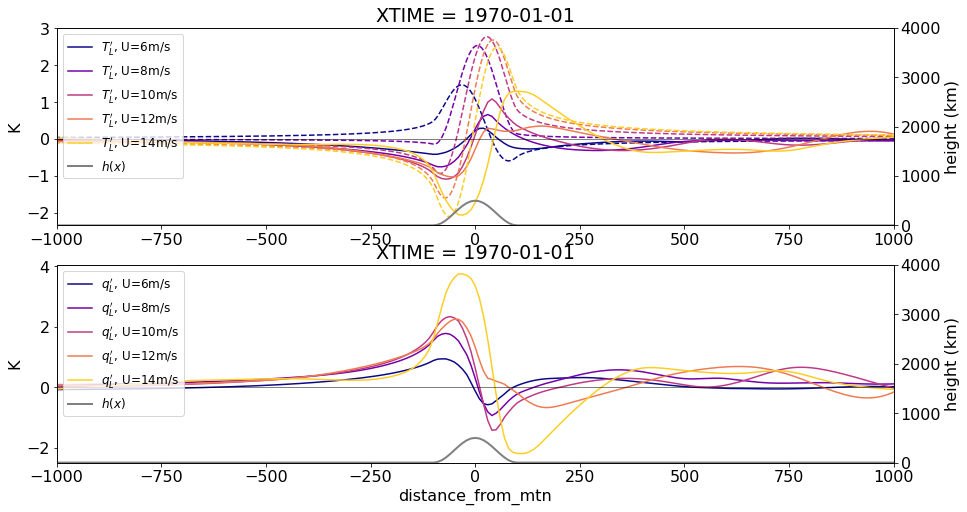

In [38]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

winds=[6,8,10,12,14]
colors=plt.cm.plasma(np.linspace(0,0.9,len(winds)))

for u,sim,c in zip(winds,sims,colors):
    # Panel a : temperature deviations
    sim.tmeanbeg_hat_prime.plot(ax=ax,label=r"$T_L'$, U=%im/s"%u,color=c)
    sim.qvmeanbeg_hat_prime.plot(ax=ax2,label=r"$q_L'$, U=%im/s"%u,color=c)
    ax.plot(*linear_TdL(u),linestyle='--',color=c)

for a,am in (ax,axm),(ax2,ax2m):
    a.axhline(0.,linestyle='-',linewidth='0.5',color='k')

    a.set_xlim(-1000,1000)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    hgt.plot(ax=am,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4000)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=12,loc=2)

ax.set_xlabel('')

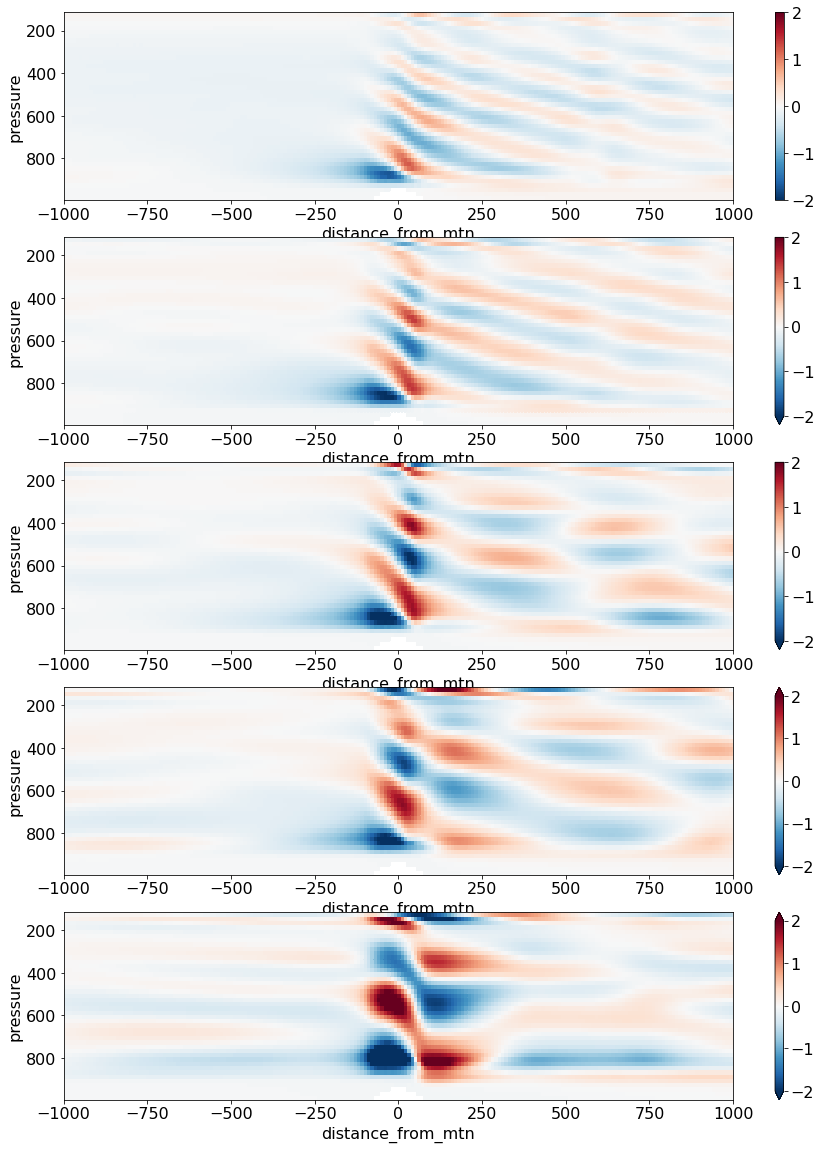

In [39]:
fig,axs = plt.subplots(5,1,figsize=(15,20))
for ax,sim in zip(axs,sims):
    (sim.tmeanbeg-sim.tmeanbeg.sel(distance_from_mtn=slice(-2500,-3000)).mean('distance_from_mtn')).plot(ax=ax,y='pressure',yincrease=False,vmin=-2,vmax=2,cmap=plt.cm.RdBu_r)
    ax.set_xlim(-1000,1000)

In [40]:
from orographicConvectionTheory.orographicConvectionTheory import k_vector,m_exponent,topographic_profile
def linear_etaL(U,N=0.012):
    xx,hx = topographic_profile('cos',a=100e3,A=1000)
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    zbot=1000
    ztop=3000
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    etahat = np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)
    return np.max(np.real(np.fft.ifft(etahat)))

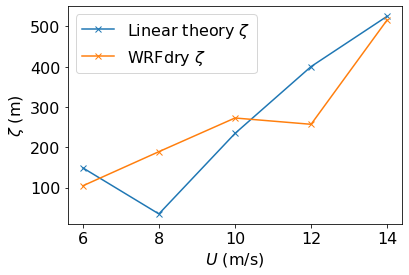

In [42]:
us = np.array([6,8,10,12,14])
etas = [linear_etaL(u) for u in us]
plt.plot(us,etas,'-x',label=r'Linear theory $\zeta$')
us_sim = np.array([6,8,10,12,14])
etas_sim = [-np.min(sim.tmeanbeg_hat_prime)/4e-3 for sim in sims]
plt.plot(us_sim,etas_sim,'-x',label=r'WRFdry $\zeta$')
plt.ylabel(r"$\zeta$ (m)")
plt.xlabel(r"$U$ (m/s)")
plt.legend()

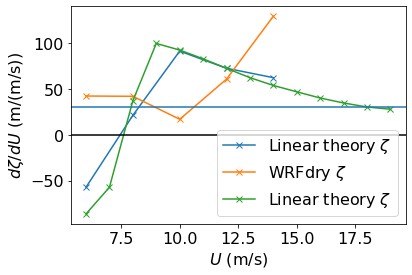

In [43]:
us = np.array([6,8,10,12,14])
etas = [linear_etaL(u) for u in us]
plt.plot(us,np.gradient(etas,us),'-x',label=r'Linear theory $\zeta$')
plt.plot(us_sim,np.gradient(etas_sim,us_sim),'-x',label=r'WRFdry $\zeta$')
us = np.arange(6,20,1)
etas = [linear_etaL(u) for u in us]
plt.plot(us,np.gradient(etas,us),'-x',label=r'Linear theory $\zeta$')

plt.axhline(30)
plt.axhline(0,color='k')
plt.ylabel(r"$d\zeta/dU$ (m/(m/s))")
plt.xlabel(r"$U$ (m/s)")
plt.legend()

In [44]:
us_sim = np.array([6,8,10,12,14])
etas_sim_2 = [-sim.tmeanbeg_hat_prime.sel(distance_from_mtn=slice(0,-200)).mean()/4e-3 for sim in sims]


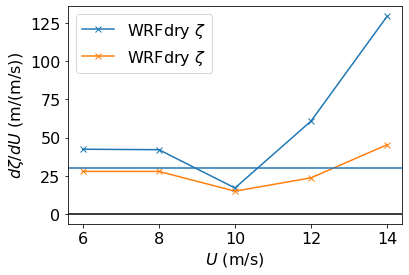

In [45]:
plt.plot(us_sim,np.gradient(etas_sim,us_sim),'-x',label=r'WRFdry $\zeta$')
plt.plot(us_sim,np.gradient(etas_sim_2,us_sim),'-x',label=r'WRFdry $\zeta$')

plt.axhline(30)
plt.axhline(0,color='k')
plt.ylabel(r"$d\zeta/dU$ (m/(m/s))")
plt.xlabel(r"$U$ (m/s)")
plt.legend()